In [2]:
## 分析组织功能性TAD模块
import pandas as pd

#print(df_TSG_hypocotyl)

## 确定包含组织功能性TAD模块
def TSG_TAD(df_TAD, df_TSG):
    df_TSG_TAD = pd.DataFrame()
    for index, row in df_TSG.iterrows():
        C, S, E = row['chrs'], row['start'], row['end']
        df_tmp = df_TAD.query("chr==@C & s<=@E & e>=@S").copy()
        df_tmp['tags'] = df_tmp['chr'] + "-" + df_tmp['s'].map(str) + "-" + df_tmp['e'].map(str)
        df_TSG_TAD = pd.concat([df_TSG_TAD, df_tmp], axis=0)
    df_TSG_TAD.drop_duplicates(inplace=True)
    return df_TSG_TAD

## 分析组织功能TAD 所能包含的基因
def TSG_TAD_gene(df_TSG_TAD, df_gene):
    df_TSG_TAD_gene = pd.DataFrame()
    for index, row in df_TSG_TAD.iterrows():
        C, S, E, T = row['chr'], row['s'], row['e'], row['tags']
        df_tmp = df_gene.query("chrs==@C & start <= @E & end >= @S").copy()
        df_tmp['tad_tags'] = [T]*df_tmp.shape[0]
        df_TSG_TAD_gene = pd.concat([df_TSG_TAD_gene, df_tmp], axis=0)
    return df_TSG_TAD_gene

# 分析每个TAD中所能包含的基因数目
def TAD_gene_number(df, tags):
    df=df[['tad_tags']].copy()
    df['number'] = [1]*df.shape[0]
    df_return = df.groupby(by=['tad_tags'], as_index=False)['number'].sum()
    df_return.rename(columns={'number':tags}, inplace=True)
    return(df_return)

# 整理基因
def data_format():
    df_gene_position = pd.read_csv('G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed', sep="\t")
    df_gene_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_mean_TPM.csv")
    df_gene_TAU = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/J668_all_tissue_TAU.csv")
    df_gene_TAU = df_gene_TAU[['GeneId', 'TAU', 'tissues']].copy()
    df_TAU_position = pd.merge(df_gene_TAU, df_gene_position, how='inner', on=['GeneId'])
    df_TAU_TPM = pd.merge(df_TAU_position, df_gene_TPM, how='inner', on=['GeneId'])
    return df_TAU_TPM

## 多列数据拉直
def data_1D(df, tags):
    #rep1, rep2, rep3 = "{}_rep1".format(tags), "{}_rep2".format(tags), "{}_rep3".format()
    df_long = pd.melt(df)
    TPM_value = df_long['value'].tolist()
    #print(TPM_value)
    return TPM_value

# ttest 双尾检验
def TPM_ttest(df, tags):
    #print(df)
    import scipy.stats as stats
    min_pvalue = 0
    samples = ['anther', 'leaf', 'root', 'stem', 'petal', 'stigma', 'cotyledon', 'hypocotyl', 'ovule', 'radicle', 'fiber_10DPA', 'fiber_20DPA']
    t1, t2, t3 = "{}_rep1".format(tags), "{}_rep2".format(tags), "{}_rep3".format(tags)
    for s in samples:
        c1, c2, c3 = "{}_rep1".format(s), "{}_rep2".format(s), "{}_rep3".format(s)
        if s not in t1:
            df_control = df[[c1, c2, c3]]
            df_treatment = df[[t1, t2, t3]]
            control_value = data_1D(df_control, s)
            treatment_value = data_1D(df_treatment, tags)
            pvalue = stats.ttest_ind(treatment_value, control_value).pvalue
            #print(pvalue)
            if min_pvalue >= pvalue:
                min_pvalue = pvalue
    if min_pvalue <= 0.05:
        return 'True'
    else:
        return 'False'    

# 分析TAD包含的基因是否具备表达差异
def TAD_gene_ttest(df, tags):
    ## 分析是否中位数与TAD所包含的组织特异表达基因相同
    df.set_index('GeneId', inplace=True)
    df_tmp = df.copy()
    #print(df)
    #print(df_tmp.median(axis=0).to_list())
    df_tmp.loc['median_values', ] = df_tmp.median(axis=0).to_list()
    max_median_tags = df_tmp.loc['median_values', ].idxmax()
    #print(df_tmp.tail())
    #print(max_median_tags, tags)
    if tags in max_median_tags:
        result = TPM_ttest(df, tags)
        return result
    else:
        return 'False'
## 分析确定TAD 是否为组织特异性TAD
def identify_TSG_TAD(df, tags):
    df_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_TPM.csv")
    # 分析判断是否为组织特异性TAD
    all_TAD = df.drop_duplicates(keep='first',subset=['tad_tags'])['tad_tags'].to_list()
    df_return = pd.DataFrame()
    for t in all_TAD:
        df_tmp = df.query("tad_tags==@t").copy()
        #print(df_tmp.head())
        df_TAD_gene = df_tmp[['GeneId']].copy() ## 找到TAD所包含的基因ID
        #print(df_TAD_gene.head())
        df_gene_TPM = pd.merge(df_TAD_gene, df_TPM, how='inner', on=['GeneId']) # 找到基因所包含的TPM
        #print(df_gene_TPM.head())
        significance_tags = TAD_gene_ttest(df_gene_TPM, tags) # 分析TAD中所包含的基因是否具备有组织显著性
        df_tmp['signif_tags'] = [significance_tags]*df_tmp.shape[0] # 给显著性加上标签
        df_return = pd.concat([df_return, df_tmp], axis=0)
    return(df_return)
# # 寻找组织特异性TAD module，以及其所能包含的可表达基因
def TAD_TSG(tags):
    df_TAU_TPM = data_format()
    df_TSG_position = df_TAU_TPM.query("TAU>=0.85 & tissues==@tags")[['GeneId', 'chrs', 'start', 'end']]
    input_TAD = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TAD_data/{0}_choosed.bed".format(tags)
    output_TAD = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{0}_TAD_TSG_number.csv".format(tags)
    df_TAD = pd.read_csv(input_TAD, sep="\t")
    df_TSG_TAD = TSG_TAD(df_TAD, df_TSG_position) # 找到包含组织特异性基因的TAD
    #print(df_TSG_TAD)
    df_TSG_TAD_all_gene = TSG_TAD_gene(df_TSG_TAD, df_TAU_TPM) # 找到组织特异性TAD 中所包含的所有基因
    df_TSG_TAD_all_exp_gene = df_TSG_TAD_all_gene[df_TSG_TAD_all_gene[tags]>=0.5] #找到组织特异性TAD 中所包含的所有可表达基因
    df_TSG_TAD_tissue_gene = df_TSG_TAD_all_exp_gene.query("tissues==@tags").copy() # 找到组织特异性TAD中表达偏向于特异的组织表达的基因
    df_TSG_TAD_tsg_gene = df_TSG_TAD_all_exp_gene.query("tissues==@tags & TAU>=0.85").copy() #找到TAD中包含的组织特异性基因
    df_TAD_all_number = TAD_gene_number(df_TSG_TAD_all_gene, "All") # TAD 包含的所有基因
    df_TAD_exp_number = TAD_gene_number(df_TSG_TAD_all_exp_gene, 'exp') # 分析所有组织特异性TAD基因所包含的可表达基因
    df_TAD_tissues_number = TAD_gene_number(df_TSG_TAD_tissue_gene, "tissueN") # 分析所有组织特异性TAD 中包含的偏向某个组织中特异表达的基因数目
    df_TAD_tsg_number = TAD_gene_number(df_TSG_TAD_tsg_gene, 'TSG') # 包含的组织特异性基因
    
    df_TSG_TAD_all_gene = df_TSG_TAD_all_gene[['GeneId', 'TAU', 'tissues', 'tad_tags']].copy()
    df_TSG_TAD_all_gene = pd.merge(df_TSG_TAD_all_gene, df_TAD_all_number, how='left', on=['tad_tags'])
    df_TSG_TAD_all_gene = pd.merge(df_TSG_TAD_all_gene, df_TAD_exp_number, how='left', on=['tad_tags'])
    df_TSG_TAD_all_gene = pd.merge(df_TSG_TAD_all_gene, df_TAD_tissues_number, how='left', on=['tad_tags'])
    df_TSG_TAD_all_gene = pd.merge(df_TSG_TAD_all_gene, df_TAD_tsg_number, how='left', on=['tad_tags'])
    #print(df_TSG_TAD_all_gene)
    df_TSG_TAD_all_gene['tissues_exp'] = df_TSG_TAD_all_gene['tissueN']/df_TSG_TAD_all_gene['exp']
    df_TSG_TAD_all_gene['TSG_exp'] = df_TSG_TAD_all_gene['TSG']/df_TSG_TAD_all_gene['tissueN']
    
    ## 分析TAD 中所包含的基因表达水平在组织间比较是否具有显著性
    df_result = identify_TSG_TAD(df_TSG_TAD_all_gene, tags)   
    df_result.to_csv(output_TAD, index=False)

#tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
#tissues = ['fiber_10DPA', 'radicle']
tissues = ['fiber_20DPA', 'ovule']
for t in tissues:
    TAD_TSG(t)

In [2]:
import pandas as pd
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/anther_TAD_TSG_number.csv")
df.drop_duplicates(keep='first', subset=['tad_tags'], inplace=True)
print(df.shape[0])

1966


In [5]:
## 分析组织功能性TAD中所包含的基因其中位数大小
import pandas as pd
tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma', 'fiber_10DPA', 'radicle', 'fiber_20DPA',  'ovule']
df_tpm = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_mean_TPM.csv")
df_result = pd.DataFrame()
for t in tissues:
    input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
    df = pd.read_csv(input_f)
    df = df[df['signif_tags']].copy()
    df_geneid = df[['GeneId']].copy()
    df_gene_TPM = pd.merge(df_geneid, df_tpm, how='inner', on=['GeneId'])
    df_gene_TPM.set_index('GeneId', inplace=True)
    df_median = pd.DataFrame(df_gene_TPM.median(axis=0))
    df_median.reset_index(inplace=True)
    df_median.columns = ['tissues', 'median_value']
    #print(df_median)
    df_median['tags'] = [t]*df_median.shape[0]
    df_result = pd.concat([df_result, df_median], axis=0)
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_TPM_median/TSG_TAD_TPM_median.csv", index=False)

In [3]:
## TSG TAD 中包含多少基因
tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma', 'fiber_10DPA', 'radicle']
for t in tissues:
    input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
    df = pd.read_csv(input_f)
    df_gene = df[df['signif_tags']].copy()
    df_tad = df_gene.drop_duplicates(keep='first', subset=['tad_tags'])
    print("gene id: ", t, df_gene.shape[0])
    print("tad id: ", t, df_tad.shape[0])

gene id:  anther 2100
tad id:  anther 307
gene id:  cotyledon 1921
tad id:  cotyledon 154
gene id:  hypocotyl 3393
tad id:  hypocotyl 165
gene id:  leaf 1818
tad id:  leaf 154
gene id:  petal 460
tad id:  petal 53
gene id:  root 4669
tad id:  root 327
gene id:  stem 2143
tad id:  stem 127
gene id:  stigma 895
tad id:  stigma 91
gene id:  fiber_10DPA 346
tad id:  fiber_10DPA 49
gene id:  radicle 4920
tad id:  radicle 334


In [9]:
## 找到TSG TAD 中的基因并且用umap 降维聚类分析
import pandas as pd

## 得到与TSG TAD相关的基因ID
def get_geneid():
    tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
    df_geneid = pd.DataFrame()
    for t in tissues:
        input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
        df = pd.read_csv(input_f)
        df_gene = df[df['signif_tags']][['GeneId']].copy()
        df_gene['tags'] = [t]*df_gene.shape[0]
        df_geneid = pd.concat([df_geneid, df_gene], axis=0)
    df_geneid.drop_duplicates(keep='first', inplace=True, subset=['GeneId'])
    return df_geneid
## 对这些基因用umap来聚类分析
def zscore_umap(df):
    import scipy.stats as stats
    from sklearn.preprocessing import StandardScaler
    import umap.umap_ as umap
    #z-score
    GeneId_list = df.index.to_list()
    df_numpy = df.to_numpy()
    df_zscore = stats.zscore(df_numpy, axis=1)
    df_zscore = pd.DataFrame(df_zscore)
    # umap
    reducer = umap.UMAP()
    scaled_penguin_data = StandardScaler().fit_transform(df_zscore)
    embedding = reducer.fit_transform(scaled_penguin_data)
    df_umap = pd.DataFrame(embedding, columns =['umap1', 'umap2'], index=GeneId_list)
    df_umap.reset_index(inplace=True)
    df_umap.rename(columns={'index':'GeneId'}, inplace=True)
    return df_umap

df_gene = get_geneid() #得到基因ID
df_geneid = df_gene[['GeneId']].copy()
## 得到基因所对应的TPM值
df_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_mean_TPM.csv")
df_gene_TPM = pd.merge(df_geneid, df_TPM, how='inner', on=['GeneId'])
df_gene_TPM.set_index(['GeneId'], inplace=True)
df_gene_TPM = df_gene_TPM.loc[~(df_gene_TPM==0).all(axis=1), :]

# # 对TPM值umap 降维
df_zscore_umap = zscore_umap(df_gene_TPM)
## 将值打上组织特异TAD 标签
df_result = pd.merge(df_zscore_umap, df_gene, how='left', on=['GeneId'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/umap_gene/J668_TSG_TAD_gene_umap.csv", index=False)
print(df_result)


                GeneId     umap1     umap2    tags
0      Ghir_A01G008470  9.527936  0.488961  anther
1      Ghir_A01G008500 -2.603051 -0.262453  anther
2      Ghir_A01G008510 -4.954781 -0.509775  anther
3      Ghir_A01G008480 -6.025434  1.622966  anther
4      Ghir_A01G010200 -0.451292 -4.578864  anther
...                ...       ...       ...     ...
15757  Ghir_D11G032400  4.159050 -5.856087  stigma
15758  Ghir_D11G032370 -1.030424 -3.357174  stigma
15759  Ghir_D11G032460  8.535477 -6.122490  stigma
15760  Ghir_D11G032440  7.220622 -4.085074  stigma
15761  Ghir_D11G032430  5.191967 -7.337708  stigma

[15762 rows x 4 columns]


In [32]:
## 找到TSG TAD 中的基因并且对每个TAD所包含基因的中位数用umap 降维聚类分析
import pandas as pd

## 得到与TSG TAD相关的基因ID
def get_geneid():
    tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
    df_geneid = pd.DataFrame()
    df_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_mean_TPM.csv")
    for t in tissues:
        input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
        df = pd.read_csv(input_f)
        df_gene = df[df['signif_tags']][['GeneId', 'tad_tags']].copy()
        df_gene = pd.merge(df_gene, df_TPM, how='inner', on=['GeneId'])
        df_gene_tags = df_gene.groupby(by=['tad_tags'])[tissues].median()
        df_gene_tags = df_gene_tags.loc[~(df_gene_tags==0).all(axis=1), :]
        #print(df_gene_tags)
        df_gene_tags['tags'] = [t]*df_gene_tags.shape[0]
        df_geneid = pd.concat([df_geneid, df_gene_tags], axis=0)
    ## 去除所有行为0的值
    
    return df_geneid
## 对这些基因用umap来聚类分析
def zscore_umap(df):
    import scipy.stats as stats
    from sklearn.preprocessing import StandardScaler
    import umap.umap_ as umap
    #z-score
    GeneId_list = df.index.to_list()
    df_numpy = df.to_numpy()
    df_zscore = stats.zscore(df_numpy, axis=1)
    df_zscore = pd.DataFrame(df_zscore)
    # umap
    reducer = umap.UMAP()
    scaled_penguin_data = StandardScaler().fit_transform(df_zscore)
    embedding = reducer.fit_transform(scaled_penguin_data)
    df_umap = pd.DataFrame(embedding, columns =['umap1', 'umap2'], index=GeneId_list)
    df_umap.reset_index(inplace=True)
    df_umap.rename(columns={'index':'tad_tags'}, inplace=True)
    return df_umap

df_gene = get_geneid() #得到基因ID
df_gene_tags = df_gene[['tags']].copy()
df_gene_tags.reset_index(inplace=True)
df_gene_median = df_gene.drop('tags', axis=1)
# # # 对TPM值umap 降维
df_zscore_umap = zscore_umap(df_gene_median)
# ## 将值打上组织特异TAD 标签
df_result = pd.merge(df_zscore_umap, df_gene_tags, how='left', on=['tad_tags'])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/umap_gene/J668_TSG_TAD_gene_median_umap.csv", index=False)
print(df_result)


                          tad_tags      umap1     umap2    tags
0     Ghir_A01-104980000-105320000  12.596522  0.785505  anther
1       Ghir_A01-14940000-15240000  10.749345  0.757841  anther
2       Ghir_A01-23680000-23880000  12.198755  2.266764  anther
3       Ghir_A01-59180000-59460000  10.644151 -0.276062  anther
4       Ghir_A01-69920000-71000000  11.630464 -0.597995  anther
...                            ...        ...       ...     ...
1368      Ghir_D11-9440000-9640000   6.991158  7.467500  stigma
1369    Ghir_D13-20620000-21200000   7.408134  7.431827  stigma
1370      Ghir_D13-3000000-3120000  11.084133  2.875095  stigma
1371    Ghir_D13-33440000-33560000   6.695797  7.828837  stigma
1372    Ghir_D13-37620000-37840000   6.264248  7.534527  stigma

[1373 rows x 4 columns]


In [67]:
## 计算TAD 基因表达中位数的皮尔逊相关系数
import pandas as pd
import numpy as np
def get_geneid():
    tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
    df_geneid = pd.DataFrame()
    df_TPM = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/RNA_Seq_data/J668_all_Tissue_mean_TPM.csv")
    for t in tissues:
        input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
        df = pd.read_csv(input_f)
        df_gene = df[df['signif_tags']][['GeneId', 'tad_tags']].copy()
        df_gene = pd.merge(df_gene, df_TPM, how='inner', on=['GeneId'])
        df_gene_tags = df_gene.groupby(by=['tad_tags'])[tissues].median()
        df_gene_tags = df_gene_tags.loc[~(df_gene_tags==0).all(axis=1), :]
        #print(df_gene_tags)
        df_gene_tags['tags'] = [t]*df_gene_tags.shape[0]
        df_geneid = pd.concat([df_geneid, df_gene_tags], axis=0)
    return df_geneid
## 将pandas 转换为两两之间的互作
def pandas_tran_net(df):
    df.index.name = 'source' # 重新修改列的标签名称
    df.columns.name = 'target'
    df_stack = df.where(np.tril(np.ones(df.shape), -1).astype(bool)).stack() # 取下三角矩阵并堆叠
    df_stack = pd.DataFrame(df_stack) # stack对象转换为dataframe
    df_stack.reset_index(inplace=True) 
    df_stack.columns = ['source', 'target', 'weight']
    df_stack['weight2'] = df_stack['weight']*df_stack['weight']*df_stack['weight']
    df_net = df_stack.query("weight>=0.5")[['source', 'target', 'weight2']] # 选择权重大于0.5的边
    df_net.columns = ['source', 'target', 'weight']
    return df_net

df = get_geneid()
df_node = df[['tags']].copy()
df_node.reset_index(inplace=True)
df_node.columns = ['ID', 'tags']
df_median = df.drop(['tags'], axis=1).T
df_median_corr = df_median.corr()
df_net = pandas_tran_net(df_median_corr)
df_net.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/corr_TAD/df_J668_TSG_TAD_net.csv", index=False)
df_node.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/corr_TAD/df_J668_TSG_TAD_node.csv", index=False)



In [29]:
import pandas as pd
import numpy as np
import scipy.stats as stats
df = pd.DataFrame(np.random.randn(100, 4), columns=list('ABCD'))
df.loc['median', ] = df.median(axis=0)
print(df.columns.to_list())
df.loc['median', ].idxmax()
stats.wilcoxon(df['A'], df['B'])

['A', 'B', 'C', 'D']


WilcoxonResult(statistic=2490.0, pvalue=0.7720894147035797)

In [293]:
import scipy.stats as stats
import numpy as np
# x = np.random.randn(1, 2)[0]
# y = np.random.randn(1, 2)[0]
x = [0.327845,0.311795,0.403644]
y = [0,0,0]
x1 = [0.327845,0.311795,0.403644]
y1 = [0,0.068981,0]
print(y1)
print(y)
print(stats.wilcoxon(x1, y1, correction=True, alternative='two-sided').pvalue)
print(stats.ttest_ind(x1, y1).pvalue)

[0, 0.068981, 0]
[0, 0, 0]
0.25
0.0008799719261802057


In [4]:
## 整理所有认为是组织功能性的TAD结构
tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma','fiber_10DPA', 'radicle']
df_result = pd.DataFrame()
for t in tissues:
    input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
    df_tmp = pd.read_csv(input_f)
    #df_tmp.replace('False', 'F', inplace=True)
    #print(df_tmp[df_tmp['signif_tags']])
    df_tmp_need = df_tmp[df_tmp['signif_tags']][['GeneId']].copy()
    df_tmp_need['tags'] = [t]*df_tmp_need.shape[0]
    #df_tmp_need.drop_duplicates(keep='first', inplace=True, subset=['tad_tags'])
    #print(df_tmp_need)
    df_result = pd.concat([df_result, df_tmp_need], axis=0)
print(df_result.shape[0])
df_result.drop_duplicates(keep='first', inplace=True, subset=['GeneId'])
print(df_result.shape[0])
df_result.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TAD_TSG_geneid.csv", index=False)

22665
21287


In [14]:
## 将WGCNA 基因调控网络转换为 TAD 共表达调控网络
#1、整理基因id所对应的TAD
def ID_TAD():
    tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
    df_id_tad = pd.DataFrame()
    for t in tissues:
        input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
        df_tmp = pd.read_csv(input_f)
        #df_tmp_need = df_tmp.query("ratio>=0.5")[['GeneId', 'tad_tags']].copy() # 之前
        df_tmp_need = df_tmp[df_tmp['signif_tags']][['GeneId', 'tad_tags']].copy() 
        df_id_tad = pd.concat([df_id_tad, df_tmp_need], axis=0)
    return df_id_tad
#2、分析组织功能TAD 共调控网络
def TAD_net(df_id_tad, df_net):
    df_id_tad.columns = ['source', 'source_tad']
    df_a = pd.merge(df_net, df_id_tad, how='inner', on=['source'])
    df_id_tad.columns = ['target', 'target_tad']
    df_b = pd.merge(df_a, df_id_tad, how='inner', on=['target'])
    df_b['number'] = [1]*df_b.shape[0]
    df_weight = df_b.groupby(by=['source_tad', 'target_tad'], as_index=False)['weight'].mean()
    return(df_weight)

df_net = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/WGCNA/J668_all_tissue_005_edge.bed", sep="\t", names=['source', 'target', 'weight'])
df_id_tad= ID_TAD()
df_TAD_net = TAD_net(df_id_tad, df_net)
df_TAD_net = df_TAD_net.query("weight>=0.2")
#print(df_TAD_net.shape[0])
df_TAD_net.columns = ['source', 'target', 'weight']
df_TAD_net.drop_duplicates(inplace=True, keep='first')
#print(df_TAD_net.shape[0])
df_TAD_net.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_net.csv", index=False)

In [8]:
## 提取TSG_TAD所包含的基因ID
import pandas as pd
tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
df_gene = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/all_gene_sort.bed2", sep="\t", names=['chrom', 'start', 'end', 'GeneId', 'tags1', 'tags2'])
for t in tissues:
    input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
    output_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_gene.bed".format(t)
    output_f2 = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_randomgene.bed".format(t)
    df_input = pd.read_csv(input_f)
    df_geneid = df_input[df_input['signif_tags']][['GeneId']].copy()
    df_output = pd.merge(df_geneid, df_gene, how='inner', on=['GeneId'])
    df_random = df_gene.sample(df_geneid.shape[0])
    df_random.to_csv(output_f2, sep="\t", index=False, header=False)
    df_output.to_csv(output_f, sep="\t", index=False, header=False, columns=['chrom', 'start', 'end', 'GeneId', 'tags1', 'tags2'])
    

In [15]:
## 给TSG_TAD打上标签
import pandas as pd

def ID_TAD():
    tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
    df_id_tad = pd.DataFrame()
    for t in tissues:
        input_f = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/{}_TAD_TSG_number.csv".format(t)
        df_tmp = pd.read_csv(input_f)
        #df_tmp_need = df_tmp.query("ratio>=0.5")[['tad_tags']].copy()
        df_tmp_need = df_tmp[df_tmp['signif_tags']][['tad_tags']].copy() 
        df_tmp_need['tissues'] = [t]*df_tmp_need.shape[0]
        df_id_tad = pd.concat([df_id_tad, df_tmp_need], axis=0)
    df_id_tad.drop_duplicates(keep='first', inplace=True,subset=['tad_tags'])
    df_id_tad.columns = ['node', 'tags']
    return df_id_tad
# 找到网络中包含的节点
def net_node(df_net):
    df_source = df_net[['source']].copy()
    df_target = df_net[['target']].copy()
    df_source.columns = ['node']
    df_target.columns = ['node']
    df_return = pd.concat([df_source, df_target], axis=0)
    df_return.drop_duplicates(keep='first',inplace=True)
    return df_return
df_TAD_net = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_net.csv")
df_TAD_node = net_node(df_TAD_net)
print(df_TAD_node.shape[0])
df_TAD_tags = ID_TAD()
df_TAD_node_tags = pd.merge(df_TAD_node, df_TAD_tags, how='left', on=['node'])
print(df_TAD_node_tags.shape[0])
df_TAD_node_tags.dropna(inplace=True)
df_TAD_node_tags.rename(columns={'node':'ID'}, inplace=True)
df_TAD_node_tags.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_node.csv", index=False)

849
849


In [7]:
## 分析TSG_TAD 所能包含的共表达网络
import pandas as pd
df_WGCNA = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/WGCNA/J668_all_tissue_005_edge.bed", sep="\t", names=['source', 'target', 'weight'])
df_geneid = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TAD_TSG_geneid.csv")
print(df_geneid.shape[0])
df_geneid = df_geneid[['GeneId']].copy()
df_geneid.columns = ['source']
df_a = pd.merge(df_geneid, df_WGCNA, how='inner', on=['source'])
df_geneid.columns = ['target']
df_b = pd.merge(df_geneid, df_a, how='inner', on=['target'])
# df_result = pd.concat([df_a, df_b], axis=0)
# df_result.drop_duplicates(keep='first', inplace=True)
df_b.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_net_gene.csv", index=False)

16698


In [5]:
import pandas as pd
df_geneid = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TAD_TSG_geneid.csv")
df_geneid.columns = ['ID', 'tags']
df_geneid.to_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/TSG_TAD_node_gene.csv", index=False)

In [63]:
## 随机生成一些基因
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/RNA_seq/Gh_gene_position.bed", sep="\t")
tissues = {'anther':2995, 'cotyledon':856, 'hypocotyl':701, 'leaf':926, 'petal':638, 'root':1827, 'stem':544, 'stigma':725}
df_result = pd.DataFrame()
for key, value in tissues.items():
    df_tmp = df.sample(value)
    df_tmp['tags'] = [key]*df_tmp.shape[0]
    df_result = pd.concat([df_result, df_tmp], axis=0)
df_result.to_csv('G:/Billfish/J668_multip_tissue_3D-genome/new_RNA_Seq/TAU/J668_all_Tissue_TSGnumber_position_random.bed', sep="\t", index=False)   
    

In [66]:
tissues = ['anther', 'cotyledon', 'hypocotyl', 'leaf', 'petal', 'root', 'stem', 'stigma']
for t in tissues:
    input_f1 = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/pre/{}_TSG.bed".format(t)
    input_f2 = "G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/pre/{}_TSG_random.bed".format(t)
    df1 = pd.read_csv(input_f1, sep="\t", names=['chrom', 'start', 'end', 'number'])
    df2 = pd.read_csv(input_f2, sep="\t", names=['chrom', 'start', 'end', 'number'])
    print(df1.shape[0], df2.shape[0])
    print(df1.query("number>1").shape[0], df2.query("number>1").shape[0])
    

1966 2081
571 608
665 763
119 77
590 634
89 57
791 789
113 97
532 572
73 46
1308 1408
318 296
484 507
52 37
611 628
83 68


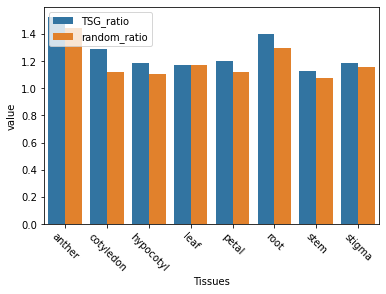

In [84]:
import pandas as pd
import seaborn as sns
df = pd.read_csv("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/pre/TSG_in_TAD_ratio.csv")
df = df[['Tissues', 'TSG_ratio', 'random_ratio']].copy()
df_long = pd.melt(df, id_vars=['Tissues'])
fg = sns.barplot(x=df_long['Tissues'], y=df_long['value'], hue=df_long['variable'])
fg.legend(loc=2)
fg.set_xticklabels(fg.get_xticklabels(), rotation=315)
scatter_fig = fg.get_figure()
scatter_fig.savefig("G:/Billfish/J668_multip_tissue_3D-genome/HiC/TAD_new/TSG_TAD/pre/TSG_in_TAD_ratio.pdf", dpi = 400)

    total  number
0       0     801
1       1    1155
2       2    1528
3       3    1958
4       4    2440
5       5    2853
6       6    3566
7       7    3913
8       8    5175
9       9    6982
10     10   11095
11     11   53657
